[View in Colaboratory](https://colab.research.google.com/github/udithv/DeepLearning/blob/master/cifar_classification.ipynb)

In [2]:
!wget https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz


Redirecting output to ‘wget-log’.


In [66]:
!ls

cifar-10-batches-py  cifar-10-python.tar.gz  sample_data  wget-log


In [4]:
!tar -xvzf cifar-10-python.tar.gz

cifar-10-batches-py/
cifar-10-batches-py/data_batch_4
cifar-10-batches-py/readme.html
cifar-10-batches-py/test_batch
cifar-10-batches-py/data_batch_3
cifar-10-batches-py/batches.meta
cifar-10-batches-py/data_batch_2
cifar-10-batches-py/data_batch_5
cifar-10-batches-py/data_batch_1


In [0]:
#CIFAR DIR
CIFAR_DIR = 'cifar-10-batches-py/'

In [0]:
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        cifar_dict = pickle.load(fo, encoding='bytes')
    return cifar_dict

In [0]:
dirs = ['batches.meta','data_batch_1','data_batch_2','data_batch_3','data_batch_4','data_batch_5','test_batch']

In [0]:
all_data = [0,1,2,3,4,5,6]

In [0]:
for i,direc in zip(all_data,dirs):
    all_data[i] = unpickle(CIFAR_DIR+direc)

In [0]:
batch_meta = all_data[0]
data_batch1 = all_data[1]
data_batch2 = all_data[2]
data_batch3 = all_data[3]
data_batch4 = all_data[4]
data_batch5 = all_data[5]
test_batch = all_data[6]

#Exploring Data


In [73]:
batch_meta

{b'label_names': [b'airplane',
  b'automobile',
  b'bird',
  b'cat',
  b'deer',
  b'dog',
  b'frog',
  b'horse',
  b'ship',
  b'truck'],
 b'num_cases_per_batch': 10000,
 b'num_vis': 3072}

In [74]:
data_batch1.keys()

dict_keys([b'batch_label', b'labels', b'data', b'filenames'])

In [75]:
type(data_batch1[b'data'])

numpy.ndarray

In [76]:
data_batch1[b'data'].shape

(10000, 3072)

In [77]:
data_batch1[b'data'][0]

array([ 59,  43,  50, ..., 140,  84,  72], dtype=uint8)

In [0]:
#since 3072 values in one row there are 3 1024(32x32) images one for each channel

In [80]:
len(data_batch1[b'labels'])
# the data_batch labels contains values 0-9 each representing an object

10000

In [0]:
#Visualizing a single image
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

In [0]:
#Assign a batch to a variable
X = data_batch1[b'data']

In [0]:
X = X.reshape(10000,3, 32, 32).transpose(0,2,3,1).astype("uint8")

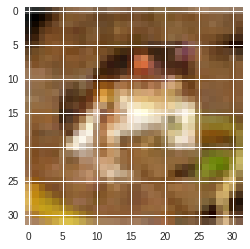

In [84]:
plt.imshow(X[0])

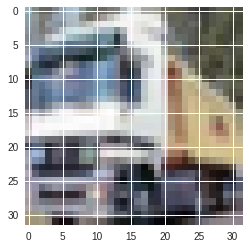

In [85]:
plt.imshow(X[1]) # kinda looks like a truck

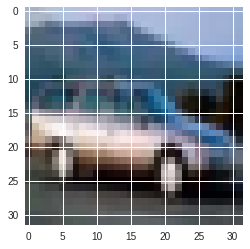

In [86]:
plt.imshow(X[4])

# Helper functions and classes for dealing with the data

In [0]:
def one_hot_encode(vec, vals=10):
    '''
    For use to one-hot encode the 10- possible labels
    '''
    n = len(vec)
    out = np.zeros((n, vals))
    out[range(n), vec] = 1
    return out

In [0]:
class CifarHelper():
    
    def __init__(self):
        self.i = 0
        
        # Grabs a list of all the data batches for training
        self.all_train_batches = [data_batch1,data_batch2,data_batch3,data_batch4,data_batch5]
        # Grabs a list of all the test batches (really just one batch)
        self.test_batch = [test_batch]
        
        # Intialize some empty variables for later on
        self.training_images = None
        self.training_labels = None
        
        self.test_images = None
        self.test_labels = None
    
    def set_up_images(self):
        
        print("Setting Up Training Images and Labels")
        
        # Vertically stacks the training images
        self.training_images = np.vstack([d[b"data"] for d in self.all_train_batches])
        train_len = len(self.training_images)
        
        # Reshapes and normalizes training images
        self.training_images = self.training_images.reshape(train_len,3,32,32).transpose(0,2,3,1)/255
        # One hot Encodes the training labels (e.g. [0,0,0,1,0,0,0,0,0,0])
        self.training_labels = one_hot_encode(np.hstack([d[b"labels"] for d in self.all_train_batches]), 10)
        
        print("Setting Up Test Images and Labels")
        
        # Vertically stacks the test images
        self.test_images = np.vstack([d[b"data"] for d in self.test_batch])
        test_len = len(self.test_images)
        
        # Reshapes and normalizes test images
        self.test_images = self.test_images.reshape(test_len,3,32,32).transpose(0,2,3,1)/255
        # One hot Encodes the test labels (e.g. [0,0,0,1,0,0,0,0,0,0])
        self.test_labels = one_hot_encode(np.hstack([d[b"labels"] for d in self.test_batch]), 10)

        
    def next_batch(self, batch_size):
        # Note that the 100 dimension in the reshape call is set by an assumed batch size of 100
        x = self.training_images[self.i:self.i+batch_size].reshape(100,32,32,3)
        y = self.training_labels[self.i:self.i+batch_size]
        self.i = (self.i + batch_size) % len(self.training_images)
        return x, y

#Creating the TensorFlow models

In [0]:
import tensorflow as tf

In [0]:
#Creating the placeholders

x = tf.placeholder(tf.float32, shape=[None, 32, 32, 3])

In [0]:
y_true = tf.placeholder(tf.float32, shape=[None, 10])

In [0]:
hold_prob = tf.placeholder(tf.float32)

In [0]:
# HELPER FUNCTIONS
def init_weights(shape):
    init_random_dist = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(init_random_dist)

In [0]:
def init_bias(shape):
    init_bias_vals = tf.constant(0.1, shape=shape)
    return tf.Variable(init_bias_vals)

In [0]:
def conv2d(x, W):
    return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')

In [0]:
def max_pool_2by2(x):
    return tf.nn.max_pool(x, ksize=[1, 2, 2, 1],
                          strides=[1, 2, 2, 1], padding='SAME')

In [0]:
def convolutional_layer(input_x, shape):
    W = init_weights(shape)
    b = init_bias([shape[3]])
    return tf.nn.relu(conv2d(input_x, W) + b)

In [0]:
def normal_full_layer(input_layer, size):
    input_size = int(input_layer.get_shape()[1])
    W = init_weights([input_size, size])
    b = init_bias([size])
    return tf.matmul(input_layer, W) + b

##Layers

In [0]:
convo_1 = convolutional_layer(x,shape=[4,4,3,32])

In [0]:
convo_1_pooling = max_pool_2by2(convo_1)

In [0]:
convo_2 = convolutional_layer(convo_1_pooling,shape=[4,4,32,64])
convo_2_pooling = max_pool_2by2(convo_2)

In [0]:
convo_2_flat = tf.reshape(convo_2_pooling,[-1,8*8*64])
full_layer_one = tf.nn.relu(normal_full_layer(convo_2_flat,1024))

In [0]:
full_one_dropout = tf.nn.dropout(full_layer_one,keep_prob=hold_prob)

In [0]:
#y_pred = normal_full_layer(full_one_dropout,10)

In [0]:
y_pred = normal_full_layer(full_one_dropout,10)

##Loss func

In [0]:
cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y_true,logits=y_pred))

In [0]:
optimizer = tf.train.AdamOptimizer(learning_rate=0.0001)
train = optimizer.minimize(cross_entropy)

In [0]:
#Intialize global Variables
init = tf.global_variables_initializer()

In [108]:
#Setting up the data
ch = CifarHelper()
ch.set_up_images()

Setting Up Training Images and Labels
Setting Up Test Images and Labels


In [62]:
x_now, y_now = ch.next_batch(100)
x_now.astype(np.float32).dtype

dtype('float32')

In [109]:
#Graph Session
steps = 5000

with tf.Session() as sess:
    
    sess.run(init)
    
    for i in range(steps):
        
        batch_x , batch_y = ch.next_batch(100)
        
        sess.run(train,feed_dict={x:batch_x,y_true:batch_y,hold_prob:0.5})
        
        # PRINT OUT A MESSAGE EVERY 100 STEPS
        if i%100 == 0:
            
            print('Currently on step {}'.format(i))
            print('Accuracy is:')
            # Test the Train Model
            matches = tf.equal(tf.argmax(y_pred,1),tf.argmax(y_true,1))

            acc = tf.reduce_mean(tf.cast(matches,tf.float32))

            print(sess.run(acc,feed_dict={x:ch.test_images,y_true:ch.test_labels,hold_prob:1.0}))
            print('\n')

Currently on step 0
Accuracy is:
0.096


Currently on step 100
Accuracy is:
0.3187


Currently on step 200
Accuracy is:
0.3852


Currently on step 300
Accuracy is:
0.4145


Currently on step 400
Accuracy is:
0.4376


Currently on step 500
Accuracy is:
0.4486


Currently on step 600
Accuracy is:
0.4673


Currently on step 700
Accuracy is:
0.4764


Currently on step 800
Accuracy is:
0.4848


Currently on step 900
Accuracy is:
0.4876


Currently on step 1000
Accuracy is:
0.4933


Currently on step 1100
Accuracy is:
0.5023


Currently on step 1200
Accuracy is:
0.5149


Currently on step 1300
Accuracy is:
0.5194


Currently on step 1400
Accuracy is:
0.5256


Currently on step 1500
Accuracy is:
0.5289


Currently on step 1600
Accuracy is:
0.5334


Currently on step 1700
Accuracy is:
0.5438


Currently on step 1800
Accuracy is:
0.5435


Currently on step 1900
Accuracy is:
0.552


Currently on step 2000
Accuracy is:
0.5567


Currently on step 2100
Accuracy is:
0.5564


Currently on step 2200
A